# Book Recommendation System with Explicit Feedback

1. [Introduction](#Introduction)
    * [Dataset](#Dataset)
    * [Factorization Machines](#Factorization-Machines)
    * [Anonymous Features Generation](#Anonymous-Features-Generation)
    * [Definitions](#Definitions)
2. [Setup](#Setup)
    * [Notebook Setup](#Notebook-Setup)
    * [Imports](#Imports)
    * [SageMaker Setup](#SageMaker-Setup)
    * [File Paths](#File-Paths)
3. [Data Preprocessing](#Data-Preprocessing)
    * [Book Deduplication](#Book-Deduplication)
    * [User Ratings Filtering](#User-Ratings-Filtering)
    * [Anonymous Features Generation](#Code-Anonymous-Features-Generation)
    * [Categorical Data Encoding](#Categorical-Data-Encoding)
    * [Upload Training Data](#Upload-Training-Data)
4. [Model Training](#Model-Training)
    * [Training Parameters](#Training-Parameters)
    * [Launch the Training Job](#Launch-the-Training-Job)
    * [Train Job](#Train-Job)
        * [Hyperparameters](#Hyperparameters)
        * [Metrics](#Metrics)
5. [Model Evaluation](#Model-Evaluation)
    * [Batch Inference](#Batch-Inference)
    * [Baselines](#Baselines)
    * [Mean Absolute Error](#MAE)
    * [Average Sorting Distance](#ASD)
    * [Pearson Correlation Coefficient](#Pearson-Correlation-Coefficient)
    * [Top N Relevance](#Top-N-Relevance)

<a id="Introduction"></a>
## Introduction
---

[This](https://github.com/edrans/-aws-sagemaker-builtin-notebooks/blob/main/factorization-machine/Explicit-feedback/Recommendation-Machine-Explicit.ipynb) notebook was used as a starting point for training a factorization machine in AWS SageMaker. The main differences between that one and this notebook are in data preprocessing, having eliminated the user features to allow for anonymous inference without retraining, and in changing the factorization machine from binary classification to regression. The reason for changing to regression is trying to obtain as many "10/10" rated books (true labels) in the top 25 / top 100 books sorted by the factorization machine predicted ratings. If using binary classification, either we'll have too few books for the positive class by choosing only the rating "10" as relevant, or we'll be unable to differentiate between 10's, 9's, 8's and 7's if we choose relevance to mean a rating of at least 7.

<a id="Dataset"></a>
### Dataset

The dataset we use is from [here](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/). However, I preprocessed it using SageMaker Data Wrangler. The main preprocessing step was creating a train/dev/test split for the user ratings in such a way as to not have the same user in multiple subsets. To download the preprocessed data click [here](https://cosminc98-public-datasets.s3.eu-central-1.amazonaws.com/books-recommender/all.zip).

<a id="Factorization-Machines"></a>
### Factorization Machines (FM)

The method we will use is a Factorization Machines regressor. FM is a general-purpose supervised learning algorithm that you can use for classification and regression tasks. It excels for extremely sparse datasets such as the one that we're dealing with since the average book has only 3 ratings and 70% of users have rated 3 books or fewer. The Amazon SageMaker FM algorithm provides a robust and highly scalable implementation of this algorithm.

FM is formulated as a linear model, with interactions between features as additional parameters (features). The basics of how it works with categorical data are the following (you can use numerical data as well but right now we do not): 
1. You one-hot encode variables that can only be from one class and multi-hot encode variables that can belong to multiple classes. The book that we want to predict the rating for is provided as input and it is one-hot encoded. Having around 200k books, this means that our one-hot encoded vector is 200k elements long. This is not a problem since we work with sparse matrices and the FM algorithm was built for this. Next, we provide a context variable, which contains all (or some of the) books that the user read and liked. This context variable belongs to multiple classes (multiple books) so we multi-hot encode it. The multi-hot encoded vector is divided by the number of classes for reasons that will be explained later. Here is what the features look like:

<div style="width:75%;margin-left:auto;margin-right:auto;">
    <figure>
        <img src="https://cosminc98-public-models.s3.eu-central-1.amazonaws.com/books-recommender/factorization-machine/anonymous_features.svg">
        <figcaption style="text-align:left"><b>Figure 1 - Anonymous Features</b>; they are anonymous because we do not one-hot encode the user ID and instead we rely on the interactions between the book that we want to rate, called target books (TB), and the books that the anonymous user said they read and liked, called context books (CB), which are provided via explicit feedback, to accurately predict if an anonymous user will like a book.</figcaption>
    </figure>
</div>

2. Each column in the feature matrix is called a feature. To each feature we assign learnable parameters: a scalar and a vector of "factors". The number of factors is usually small since the data is very sparse and the model can quickly overfit it. In our case, we use either 4 or 8 factors. There is also a global scalar that is shared between all features.

3. For a given input sample $\textbf{x}_i$ (made of the features described earlier), the predicted rating $\hat{y}(\textbf{x}_i)$ is computed as follows:
$$\hat{y}(\textbf{x}_i) = w_0 + \sum_{j=1}^{n}{w_jx_{ij}} + \sum_{j=1}^{n}{\sum_{k=j+1}^{n}{<\textbf{v}_j, \textbf{v}_k>x_{ij}x_{ik}}}$$
    * $n$ is the number of features in the input sample (length of the one-hot and multi-hot encoded vectors combined).
    * $w_0$ is the global scalar learnable parameter; this may be used by the model as a base rating (could be the average ratings of the training set, although not necessarily) from which we go up or down depending on what particular book we are evaluating.
    * $w_1, w_2, w_3, ... w_n$ are scalars specific to each feature; this may describe how much larger the average rating of a given book is than the average rating of all books in the dataset.
    * $\textbf{v}_j$ is the vector of factors in the latent space of feature embeddings. Each factor vector represents a book in our case. Basically, if two books are similar then they will have factor vectors that are close in the latent space.
    * $<\textbf{v}_j, \textbf{v}_k>$ is the dot product of two vectors $\textbf{v}_j$ and $\textbf{v}_k$. The dot product is used here to evaluate the similarity between the factor vectors. If the dot product is small or 0 then these two books have nothing in common and will not affect the result. If the dot product is negative then these books are opposites and the predicted rating will decrease. If the dot product is positive then these books are similar and the predicted rating will increase.

The reason we divide the context features from Figure 1 by the number of non-zero elements is that we don't want the interaction between the target book and context books to become insignificant when increasing the number of context books. This would happen
because the factorization machine also computes the dot products of any combination of two context books.

<a id="Anonymous-Features-Generation"></a>
### Anonymous Features Generation

In our application we will have anonymous users provide a few books that they liked and we need to give them book recommendations based on those. Because of this, we will not use users as a feature. As we can see in Figure 1, we need tuples of 3 elements in order to perform training:
1. Target Book ISBN
2. Target Book Rating (needed for training but not for inference)
3. List of Context Books ISBNs

The problem is that our dataset provides us with tuples of the following 3 elements:
1. Target Book ISBN
2. Target Book Rating
3. User ID

In order to transform the latter into the former, we need to group all the ratings of each user and choose combinations of "liked books" (books with ratings >= 7, for example) and use them as context for another book that wasn't chosen this iteration to be in the context list.

<a id="Definitions"></a>
### Definitions
| Term | Definition |
|:--- |:--- | 
| Context Book | A book that is provided by the user, with the assumption that they liked it (explicit feedback), that will be used to rank recommendations using the factorization machine model. The context books are only a subset of the book dataset since some books did not have enough data during training. **Users may only choose liked books from this subset.** |
| Target Book | A book that can be scored by the factorization machine model. The target books are only a subset of the book dataset since some books did not have enough data during training. **Users will receive recommendations only from this subset.** |
| ISBN | International Standard Book Numbers (or ISBN) is a unique identified for each book. In particular, it is an identified for each specific version/revision of a given book, which is why we need to perform ISBN deduplication to map old versions to the latest one. We do this to treat all versions of the same book in as one single book. |

<a id="Setup"></a>
## Setup
---

<a id='Notebook-Setup'></a>
### Notebook Setup
This notebook was tested in Amazon SageMaker Studio on a ml.m5.large instance with Python 3 (Data Science) kernel.

<a id='Imports'></a>
### Imports

In [2]:
# built-ins
import io
import os
import re
import json
import random
import math
import itertools
import pickle
import uuid
from heapq import heappush, heappop
from functools import partial
from typing import Dict, List, Tuple, Iterable, Generator, Optional

# preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from scipy.sparse import diags, hstack

# evaluation
from sklearn.metrics import mean_absolute_error

# sagemaker imports
import boto3
import sagemaker
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
from sagemaker.deserializers import JSONDeserializer

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


<a id='SageMaker-Setup'></a>
### SageMaker Setup
We need to specify:
+ The IAM role arn used to give training and hosting access to your data.
+ The S3 buckets and prefixes that we want to use to upload training and test data for the SageMaker Factorization Machine algorithm to use as input, and the s3 location where to save the model parameters after training is finished.


In [3]:
role = get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "books-recommender/anonymous-regressor"
print(f"role: {role} bucket: {bucket}")

train_key = 'train.protobuf'
train_prefix = '{}/{}'.format(prefix, 'train')
s3_train = 's3://{}/{}/train/'.format(bucket,prefix)

test_key = 'test.protobuf'
test_prefix = '{}/{}'.format(prefix, 'test')

output_prefix = 's3://{}/{}/output'.format(bucket, prefix)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
role: arn:aws:iam::663187321862:role/service-role/AmazonSageMaker-ExecutionRole-20231121T160023 bucket: sagemaker-eu-central-1-663187321862


<a id="File-Paths"></a>
### File Paths

In [4]:
data_dir = "../../../data"
books_fpath = os.path.join(data_dir, "books", "books.csv")
ratings_train_fpath = os.path.join(data_dir, "books", "ratings-train.csv")
ratings_val_fpath = os.path.join(data_dir, "books", "ratings-val.csv")

<a id='Data-Preprocessing'></a>

## Data Preprocessing
---

<a id="Preprocessing-Book-Deduplication"></a>
### Book Deduplication
There are multiple versions of the same book (each having a different ISBN). Because of this, the average ISBN has a lower number of ratings. If we consolidate all of the ratings of related ISBNs (different versions of the same book) into the latest version ISBN then we would improve model performance. In this section we produce a map that takes old ISBN and converts them to the latest one.

TODOs:
- [ ] Implement a smarter deduplication algorithm, one that translates the titles of all books to english, that allows small differences in the author name and book title, etc.

In [5]:
books_df = pd.read_csv(books_fpath, dtype={
    "ISBN": str, 
    "BookTitle": str, 
    "BookAuthor": str, 
    "YearOfPublication": int, 
    "Publisher": str, 
    "ImageURLSmall": str, 
    "ImageURLMedium": str, 
    "ImageURLLarge": str
})
books_df.head().iloc[: , :5]

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher
0,1565920317,!%@ (A Nutshell handbook),Donnalyn Frey,1993,O'Reilly
1,1565920465,!%@ (A Nutshell handbook),Donnalyn Frey,1994,O'Reilly
2,0133989429,!Arriba! Comunicacion y cultura,Eduardo Zayas-Bazan,1996,Prentice Hall
3,013327974X,"!Trato hecho!: Spanish for Real Life, Combined...",John T. McMinn,1995,Prentice Hall
4,0452279186,!Yo!,Julia Alvarez,1997,Plume Books


In [6]:
# add a new column that takes the title and author and combines them (to identify duplicate titles of the same author)
def simplify_text(text: str) -> str:
    return re.sub('\W+','', text).lower().strip()
books_df["BookTitleSimple"] = books_df["BookTitle"].apply(simplify_text)
books_df["BookAuthorSimple"] = books_df["BookAuthor"].apply(simplify_text)
books_df["TitleAndAuthor"] = books_df[["BookTitleSimple", "BookAuthorSimple"]].apply(lambda x: "|".join(x), axis=1)
books_df["TitleAndAuthor"].head()

0                       anutshellhandbook|donnalynfrey
1                       anutshellhandbook|donnalynfrey
2         arribacomunicacionycultura|eduardozayasbazan
3    tratohechospanishforreallifecombinededition|jo...
4                                      yo|juliaalvarez
Name: TitleAndAuthor, dtype: object

In [7]:
# now we can see that about 22k books (about 8.3% of the total number of ISBNs) 
# are truly duplicated (there may be more, if the book title or author name is written differently)
# 25k = 264k (initial ISBNs) - 239k (after deduplication)
print("Books by number of duplicates:")
books_df.TitleAndAuthor.value_counts().describe(percentiles=[0.9, 0.92, 0.93, 0.985, 0.995, 0.999])

Books by number of duplicates:


count    239338.000000
mean          1.102934
std           0.421108
min           1.000000
50%           1.000000
90%           1.000000
92%           1.000000
93%           2.000000
98.5%         2.000000
99.5%         3.000000
99.9%         5.000000
max          21.000000
Name: TitleAndAuthor, dtype: float64

In [8]:
%%time
# create a map from duplicate ISBNs to the latest ISBN version of that book
same_book_isbn_map: Dict[str, str] = {}

title_to_isbn: Dict[str, Tuple[str, int, List[str]]] = {}
for _, row in books_df.iterrows():
    title_and_author = row["TitleAndAuthor"]
    if title_and_author in title_to_isbn:
        curr_isbn, curr_pub_year, other_isbns = title_to_isbn[title_and_author]
        # if the same book title and author is found then the book was 
        # published in two separate editions; we take the edition that was 
        # published last, or if the publication year is the same then the one
        # with the largest ISBN (they will have different ISBNs because they
        # are registered as different books)
        if curr_pub_year < row["YearOfPublication"] or (curr_pub_year == row["YearOfPublication"] and curr_isbn < row["ISBN"]):
            # this duplicate was published later than the previous one
            other_isbns.append(curr_isbn)
            title_to_isbn[title_and_author] = (row["ISBN"], row["YearOfPublication"], other_isbns)
        else:
            # this duplicate is older than the one we currently have stored
            other_isbns.append(row["ISBN"])
    else:
        title_to_isbn[title_and_author] = (row["ISBN"], row["YearOfPublication"], [])
        
for _, (isbn, _, other_isbns) in title_to_isbn.items():
    if len(other_isbns) > 0:
        for other_isbn in other_isbns:
            same_book_isbn_map[other_isbn] = isbn
            
# we have a map from every duplicate ISBN to the latest published version of 
# that book (latest ISBN)
print(f"The number of duplicates is {len(same_book_isbn_map)}")
with open("same_book_isbn_map.json", "w") as f:
    f.write(json.dumps(same_book_isbn_map))

The number of duplicates is 24636
CPU times: user 10.7 s, sys: 41.1 ms, total: 10.8 s
Wall time: 10.8 s


In [9]:
# get a list of all correct ISBNs based on the format described here:
# https://en.wikipedia.org/wiki/ISBN for the ISBN-10
def check_isbn_format(isbn: str) -> bool:
    if len(isbn) != 10:
        return False
    if re.match(r"[0-9]{9}[0-9X]", isbn) is None:
        return False  
    return True
good_isbns = set(filter(check_isbn_format, list(books_df.ISBN.unique())))

with open("valid_isbn.json", "w") as f:
    f.write(json.dumps(list(good_isbns)))

<a id="Preprocessing-Book-Deduplication"></a>
### User Ratings Filtering

In [10]:
def map_if_duplicate(isbn: str, same_book_isbn_map: Dict[str, str]) -> str:
    if isbn in same_book_isbn_map:
        return same_book_isbn_map[isbn]
    return isbn

def read_user_ratings(file_path: str, same_book_isbn_map: Dict[str, str]) -> pd.DataFrame:
    df = pd.read_csv(file_path, dtype={"UserID": str, "ISBN": str, "BookRating": int})
    df = df[df.ISBN.isin(good_isbns)]
    df["ISBN"] = df["ISBN"].apply(partial(map_if_duplicate, same_book_isbn_map=same_book_isbn_map))
    df.drop_duplicates(subset=["UserID", "ISBN"], keep="last", inplace=True)
    return df

ratings_train_df = read_user_ratings(ratings_train_fpath, same_book_isbn_map)
ratings_test_df = read_user_ratings(ratings_val_fpath, same_book_isbn_map)
ratings_train_df.head()

,UserID,ISBN,BookRating
0,25409,081296666X,10
1,25533,0440910846,0
2,26182,1570625190,0
3,26624,0698119517,0
4,26731,0515087947,0


In [11]:
print("The distribution of users based on how many books they rated:")
ratings_train_df.UserID.value_counts().describe(percentiles=[0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

The distribution of users based on how many books they rated:


count    80043.000000
mean        11.300913
std         90.128380
min          1.000000
50%          1.000000
60%          2.000000
70%          3.000000
80%          5.000000
90%         13.000000
95%         31.000000
99%        180.000000
max      10267.000000
Name: UserID, dtype: float64

In [12]:
# create a map from ISBN to the average rating of that book; will be used by
# the baseline predictor to which we will compare our model
avg_df = ratings_train_df.groupby('ISBN') \
   .agg({'UserID':'size', 'BookRating':'mean'}) \
   .rename(columns={'UserID':'Count','BookRating':'AvgRating'}) \
   .reset_index()
isbn_to_avg_rating = dict(zip(avg_df.ISBN, avg_df.AvgRating))

In [13]:
def filter_and_sample_users_by_n_ratings(
    ratings: pd.DataFrame, 
    min_ratings: int = 2, 
    max_ratings: Optional[int] = 200,
) -> pd.DataFrame:
    """
    Filter out users with too few book ratings. Optionally, sample the ratings
    of users that have too many.
    
    Args:
        ratings: A pandas dataframe with the "UserID", "ISBN" and "BookRating" 
            columns, representing all book ratings of users in a given split.
        min_ratings: The minimum number of books each given user must have 
            rated to not be filtered out. Defaults to 2.
        max_ratings: The maximum number of book ratings per user. If not None, 
            will sample this number of ratings for each user. Defaults to 200.
            
    Returns:
        The dataframe with the filtered ratings.
    """

    users_with_min_ratings = ratings.UserID.value_counts() >= min_ratings
    filtered_users = set(users_with_min_ratings.keys()[users_with_min_ratings.values])

    filtered_ratings = ratings[ratings["UserID"].isin(filtered_users)]
    filtered_ratings = filtered_ratings.groupby("UserID", as_index=False).nth(range(max_ratings))
    return filtered_ratings

In [14]:
ratings_train_filtered = filter_and_sample_users_by_n_ratings(ratings_train_df, max_ratings=200)

# remove the books from the test subset that are not in the training set.
ratings_test_df = ratings_test_df[ratings_test_df.ISBN.isin(ratings_train_filtered.ISBN)]
ratings_test_filtered = filter_and_sample_users_by_n_ratings(ratings_test_df, max_ratings=200)

print("The distribution of users based on how many books they rated (after filtering):")
ratings_train_filtered.UserID.value_counts().describe(percentiles=[0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

The distribution of users based on how many books they rated (after filtering):


count    35616.000000
mean        16.319547
std         35.315135
min          2.000000
50%          4.000000
60%          6.000000
70%          9.000000
80%         15.000000
90%         35.000000
95%         79.000000
99%        200.000000
max        200.000000
Name: UserID, dtype: float64

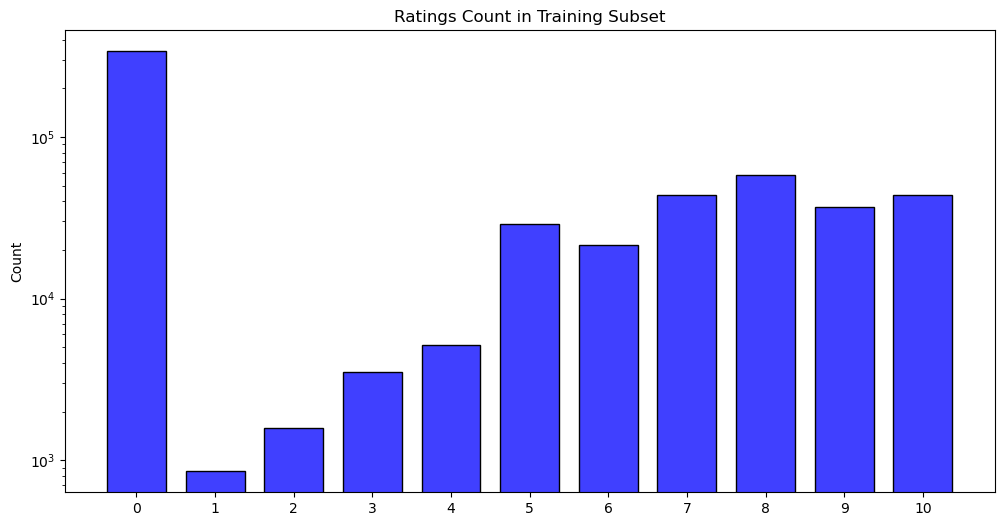

In [15]:
plt.figure(figsize=(12,6))
plt.title("Ratings Count in Training Subset")
g = sns.histplot(
    data=pd.Categorical(ratings_train_filtered.BookRating, range(11)),
    color="blue",
    bins=range(11),
    shrink=0.75,
    log_scale=(False, True),
)
g.set_xticks(range(11)) 
plt.show()

In [16]:
print("Distribution of books by the number of users that rated them:")
ratings_train_filtered.ISBN.value_counts().describe(percentiles=[0.75, 0.8, 0.9, 0.99])

Distribution of books by the number of users that rated them:


count    170978.000000
mean          3.399484
std          12.533837
min           1.000000
50%           1.000000
75%           2.000000
80%           3.000000
90%           5.000000
99%          38.000000
max        1593.000000
Name: ISBN, dtype: float64

<a id="Code-Anonymous-Features-Generation"></a>
### Anonymous Features Generation

In [17]:
def random_combinations(
    iterable: Iterable, 
    combination_size: int, 
    n_combinations: int, 
    sampling_start=1000
) -> List[Tuple]:
    """
    Generate random combinations (without replacement) of a given size from the
    items of an iterable. Makes use of random sampling to avoid generating too 
    many combinations (which will blow up memory).

    Args:
        iterable: The iterable that contains the items to be sampled
            in combinations.
        combination_size: The number of items to sample per combination.
        n_combinations: The number of combinations of items to return.
            The actual number of returned combinations may be lower.

    Returns:
        A list of tuples, where each tuple is a unique combination of items 
        from the iterable object.
    """
    items = tuple(iterable)
    assert combination_size <= len(items)

    total_combinations = math.comb(len(items), combination_size)

    # only use sampling if we would need to store in memory at least "sampling_start"
    # combinations AND if we need to sample an order of magnitude fewer combinations
    # than the total amount of combinations available
    if total_combinations >= sampling_start and total_combinations > 10 * n_combinations:
        combinations = set()

        while True:
            indices = sorted(random.sample(range(len(items)), combination_size))
            combination = tuple(items[i] for i in indices)
            if combination not in combinations:
                combinations.add(combination)
                if len(combinations) >= n_combinations:
                    break

        combinations = list(combinations)
    else:
        combinations = list(itertools.combinations(iterable, combination_size))

    random.shuffle(combinations)
    return combinations[:n_combinations]

iters = [
    random_combinations(range(4), 1, 4),
    random_combinations(range(10), 2, 2),
]
for x in filter(lambda x: x is not None, itertools.chain(*itertools.zip_longest(*iters, fillvalue=None))):
    print(x)

(2,)
(2, 3)
(3,)
(2, 4)
(0,)
(1,)


In [18]:
def generate_sample_context(
    liked_books: Iterable[str], 
    max_samples: int, 
    min_size: int = 1, 
    max_size: int = 5
) -> Generator[Tuple[str, ...], None, None]:
    """
    Generator of sample contexts. Each user may have tens or hundreds of liked 
    books, but we would like to use only a few of these at a time to predict
    the rating of a movie that the user did not yet watch.

    Args:
        liked_books: The IDs (ISBN) of the books that a given user has liked.
        max_samples: The maximum number of sample contexts that will be 
            generated.
        min_size: The minimum context size.
        max_size: The maximum context size.

    Returns:
        A generator of sample contexts, which returns contexts of alternating 
        sizes.
    """

    n_sizes = max_size - min_size + 1
    if n_sizes <= 0:
        return

    iters = []
    for size in range(min_size, max_size+1):
        iters.append(random_combinations(liked_books, size, max_samples // n_sizes * 2))

    # each input iterator (from "iters") returns sample contexts of a fixed 
    # size and we want to alternate the context sizes; for this we zip all
    # iterators, using zip_longest to fill shorter iterators with None
    zip_iters = itertools.zip_longest(*iters, fillvalue=None)

    # we then parse each zipped tuple, which contains one context of each
    # size; with min_size=1 and max_size=3, we would obtain at the output of 
    # this generator, contexts of size 1, 2, 3, 1, 2, 3, etc.
    chain_iters = itertools.chain(*zip_iters)

    # filter out None since some iterators will be shorter than others (there
    # are far fewer combinations of size 1 than there are of size 2 or 3)
    contexts_alternating_sizes = filter(lambda x: x is not None, chain_iters)

    for index, context in enumerate(contexts_alternating_sizes):
        if index >= max_samples:
            return
        yield context


def generate_user_samples(
    user_ratings: List[Tuple[str, int]],
    min_context_size: int, 
    max_context_size: int, 
    like_min_rating: int = 7, 
    amplification_factor: int = 5
) -> List[Tuple[int, str, Tuple[str, ...]]]:
    """
    Args:
        user_ratings: List of tuples, where each tuple contains an ISBN and the
            rating that the user gave that book.
        min_context_size: The minimum number of books that are used to describe
            the user preferences when predicting the rating of another book.
        max_context_size: The maximum number of books that are used to describe
            the user preferences when predicting the rating of another book.
        like_min_rating: An integer 0 <= x <= 10, which represents the
            minimum rating to consider a book as "liked" by the user.
        amplification_factor: The maximum number of times each book
            rating can be duplicated in the output dataset. The duplicates
            will necessarily have a different context (the liked books).
            We do this because each book has, on average, 2-3 ratings from
            users, which is a very small number to do machine learning with.
            With the amplification factor of 5, we should have 10-15 samples
            per book, on average. While the rating itself (0-10) will be the
            same, the context for each duplicate will be different, limiting
            overfitting.

    Returns:
        A list of samples used for training or testing. These consist of a 
        target rating, which the model needs to predict, the ID (ISBN) of the 
        book for which we are predicting, and a list of book IDs providing a 
        context for the user (which other books he liked).
    """
    if like_min_rating not in range(11):
        raise ValueError('Argument "like_min_rating" should be a value in 0 <= x <= 10')

    if not amplification_factor > 0:
        raise ValueError('Argument "amplification_factor" must be greater than 0')

    liked_books = [x[0] for x in user_ratings if x[1] >= like_min_rating]
    if len(liked_books) == 0:
        return []

    samples = []
    max_samples = int(amplification_factor * len(user_ratings))

    context_generator = generate_sample_context(
        liked_books=liked_books, 
        max_samples=max_samples, 
        min_size=min_context_size, 
        max_size=min(max_context_size, len(user_ratings)-1, len(liked_books)),
    )

    liked_books_set = set(liked_books)
    target_heap_counter = []
    for book_id, book_rating in user_ratings:
        # give the liked books a slightly smaller value to be retrieved before
        # the other books; the reasoning is that because they are included in 
        # the context it will be harder to use them as the target book so we 
        # need to try to use them as quickly as possible
        if book_id in liked_books_set:
            heap_counter = 0
        else:
            heap_counter = 0.5
        heappush(target_heap_counter, (heap_counter, (book_id, book_rating)))

    for context in context_generator:
        # buffer to reinsert books extracted from the heap that could not be
        # used as targets for this contexts because they are in the context
        buff = []
        context_set = set(context)

        while len(target_heap_counter) > 0:
            target_candidate = heappop(target_heap_counter)
            heap_counter, (book_id, book_rating) = target_candidate
            if book_id in context_set:
                buff.append(target_candidate)
            else:
                if book_rating == 0:
                    # this should reduce the number of copies of samples with 0
                    # as their rating; we do this because they are 
                    # overrepresented
                    heap_counter += 2
                elif book_rating < 5:
                    # the ratings between 1 and 4 (inclusive) are 
                    # underrepresented; we count them slower to than other 
                    # ratings to include more of them overwall
                    heap_counter += 0.75
                else:
                    heap_counter += 1

                heappush(target_heap_counter, (heap_counter, (book_id, book_rating)))
                samples.append((book_rating, book_id, context))
                break

        if len(target_heap_counter) == 0:
            raise RuntimeError(f"Could not find a good candidate for the given context: {context}")

        for rejected_candidate in buff:
            heappush(target_heap_counter, rejected_candidate)
            
    random.shuffle(samples)
    
    return samples
    

def generate_anonymous_samples(
    ratings: pd.DataFrame, 
    min_context_size: int, 
    max_context_size: int,
    like_min_rating: int = 7, 
    amplification_factor: int = 5,
    books: Optional[pd.DataFrame] = None,
):
    """
    Args:
        ratings (pd.DataFrame): A pandas dataframe containing book ratings from
            various users.
        min_context_size: The minimum number of books that are used to describe
            the user preferences when predicting the rating of another book.
        max_context_size: The maximum number of books that are used to describe
            the user preferences when predicting the rating of another book.
        like_min_rating: An integer 0 <= x <= 10, which represents the
            minimum rating to consider a book as "liked" by the user.
        amplification_factor: The maximum number of times each book
            rating can be duplicated in the output dataset. The duplicates
            will necessarily have a different context (the liked books).
            We do this because each book has, on average, 2-3 ratings from
            users, which is a very small number to do machine learning with.
            With the amplification factor of 5, we should have 10-15 samples
            per book, on average. While the rating itself (0-10) will be the
            same, the context for each duplicate will be different, limiting
            overfitting.
        books: WARNING, experimental feature. For now it's not clear if it helps
            or hurts the model. If not None, will generate a fan user for each 
            author. Each fan will have read all of the books from that author 
            and given them a rating of 10. The reasoning for this is boosting 
            the score of a book when another book from the same author is used 
            as context.

    Returns:
        A list of samples used for training or testing. These consist of a 
        target rating, which the model needs to predict, the ID (ISBN) of the 
        book for which we are predicting, and a list of book IDs providing a 
        context for the user (which other books he liked).
    """
    samples = []
    for user_id, user_ratings in ratings.groupby("UserID"):
        if len(user_ratings) == 1:
            raise ValueError(f"User {user_id} only has 1 rated book")
        samples.extend(
            generate_user_samples(
                user_ratings=list(zip(user_ratings.ISBN, user_ratings.BookRating)), 
                min_context_size=min_context_size, 
                max_context_size=max_context_size, 
                amplification_factor=amplification_factor
            )
        )
        
    if books is not None:
        books_with_real_rating = set(x[1] for x in samples)
        books = books[books.ISBN.isin(books_with_real_rating)]
        for author_name, author_df in books.groupby("BookAuthorSimple"):
            if len(author_df) == 1:
                continue
            samples.extend(
                generate_user_samples(
                    user_ratings=list(zip(author_df.ISBN, itertools.repeat(10))), 
                    min_context_size=min_context_size, 
                    max_context_size=max_context_size, 
                    amplification_factor=amplification_factor
                )
            )
        
    random.shuffle(samples)
    
    ratings = pd.Series(data=[x[0] for x in samples], name="BookRating")
    book_ids = pd.Series(data=[x[1] for x in samples], name="ISBN")
    contexts = [x[2] for x in samples]
    
    return ratings, book_ids, contexts

In [19]:
%%time
ratings_train, book_ids_train, contexts_train = generate_anonymous_samples(
    ratings=ratings_train_filtered, 
    min_context_size=1, 
    max_context_size=10, 
    amplification_factor=5,
    # books=books_df,
)
ratings_test, book_ids_test, contexts_test = generate_anonymous_samples(ratings_test_filtered, 5, 10)

CPU times: user 31.7 s, sys: 185 ms, total: 31.8 s
Wall time: 31.9 s


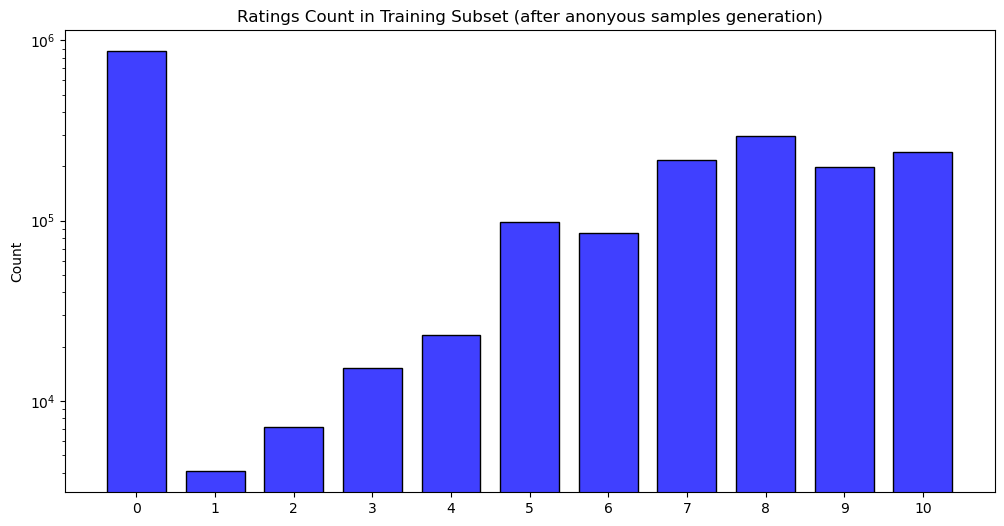

In [20]:
plt.figure(figsize=(12,6))
plt.title("Ratings Count in Training Subset (after anonyous samples generation)")
g = sns.histplot(
    data=pd.Categorical(ratings_train, range(11)),
    color="blue",
    bins=range(11),
    shrink=0.75,
    log_scale=(False, True),
)
g.set_xticks(range(11)) 
plt.show()

In [21]:
%%capture
# create regression target with values between 0 and 1
target_train = (ratings_train / 10).astype("float32")
target_train.rename("TargetTrain", inplace=True)
target_test = (ratings_test / 10).astype("float32")
target_test.rename("TargetTest", inplace=True)

<a id='Categorical-Data-Encoding'></a>
### Categorical Data Encoding

In order to convert categorical data to numbers for our model we need to use one-hot and multi-hot encoding. The target vector contains only one class (the book for which we are predicting the rating), and therefore can be one-hot encoded. The context vector contains multiple classes (the explicit feedback provided by the anonymous user; e.g. the books he read and liked), and therefore should be multi-hot encoded.

In [22]:
target_id_encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
target_id_encoder.fit(np.array(list(set(book_ids_train))).reshape(-1, 1))
target_id_encoder.categories_[0].shape
# save the target encoder to file
with open("target_encoder.pkl", "wb") as f: 
    pickle.dump(target_id_encoder, f)

In [23]:
context_encoder = MultiLabelBinarizer(sparse_output=True)
context_encoder.fit(np.array(list(set(ratings_train_filtered.ISBN))).reshape(-1, 1))
context_encoder.classes_.shape
# save the context encoder to file
with open("context_encoder.pkl", "wb") as f: 
    pickle.dump(context_encoder, f)

In [24]:
# turn the target ids into one-hot encoded vectors (represented with sparse matrices)
X_train_target_ids = target_id_encoder.transform(np.array(book_ids_train).reshape(-1, 1)).astype('float32')
X_test_target_ids = target_id_encoder.transform(np.array(book_ids_test).reshape(-1, 1)).astype('float32')

# check that no entries were ignored by the encoder; this could happen if there
# are books in the test set that are not in the training set
assert X_train_target_ids.shape[0] == len(book_ids_train)
assert X_test_target_ids.shape[0] == len(book_ids_test)

In [25]:
# turn the context ids into one-hot encoded vectors (represented with sparse 
# matrices) and divide each context vector by the number of non-zero elements
# (see introduction for explanations)
X_train_context = (diags([1 / len(x) for x in contexts_train]) * context_encoder.transform(contexts_train)).astype('float32')
X_test_context = (diags([1 / len(x) for x in contexts_test]) * context_encoder.transform(contexts_test)).astype('float32')

assert X_train_context.shape[0] == len(book_ids_train)
assert X_test_context.shape[0] == len(book_ids_test)

In [26]:
# merge the one hot encoded target book id and the weighted multi-hot encoded
# context, which is made of multiple "liked" book ids
X_test = hstack([X_test_target_ids, X_test_context], format="csr")
X_train = hstack([X_train_target_ids, X_train_context], format="csr")

assert X_test.shape[1] == X_test_target_ids.shape[1] + X_test_context.shape[1]
assert X_test.shape[0] == X_test_target_ids.shape[0] and X_test_target_ids.shape[0] == X_test_context.shape[0]
assert X_train.shape[1] == X_train_target_ids.shape[1] + X_train_context.shape[1]
assert X_train.shape[0] == X_train_target_ids.shape[0] and X_train_target_ids.shape[0] == X_train_context.shape[0]

In [27]:
Y_train = target_train
Y_test = target_test
columns = X_train.shape[1]

<a id='Upload-Training-Data'></a>
### Upload Training Data

The Amazon SageMaker implementation of Factorization Machines takes RecordIO-wrapped protobuf as input.

In [28]:
def write_dataset_to_protobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [29]:
%%time   
test_data = write_dataset_to_protobuf(X_test, Y_test, bucket, test_prefix, test_key)    
train_data = write_dataset_to_protobuf(X_train, Y_train, bucket, train_prefix, train_key) 
print(train_data)
print(test_data)

s3://sagemaker-eu-central-1-663187321862/books-recommender/anonymous-regressor/train/train.protobuf
s3://sagemaker-eu-central-1-663187321862/books-recommender/anonymous-regressor/test/test.protobuf
CPU times: user 2min 41s, sys: 5.47 s, total: 2min 46s
Wall time: 2min 41s


<a id='Model-Training'></a>
## Model Training
---

Now that we are done with all the setup that is needed, we are ready to train our Factorization Machine. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

<a id='Training-Parameters'></a>
### Training Parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **image_uri**: Container image for the algorithm
* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the Factorization Machine algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. 
* **Volume size**: Size in GB of the EBS volume to use for storing input data during training. Must be large enough to store training data.
* **Max run time**: Timeout in seconds for training. After this amount of time Amazon SageMaker terminates the job regardless of its current status.
* **Output path**: This the s3 folder in which the training output is stored.

In [30]:
training_image = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name, 
    framework="factorization-machines", 
    version='latest'
)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [31]:
fm = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    volume_size=30,
    max_run=86400,
    output_path=output_prefix,
    sagemaker_session=sess,
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **feature_dim**: The dimension of the input feature space. This could be very high with sparse input.
* **num_factors**: The dimensionality of factorization. As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.
* **predictor_type**: The type of predictor. binary_classifier: For binary classification tasks. regressor: For regression tasks.
* **epochs**: The number of training epochs to run.
* **mini_batch_size**: The size of mini-batch used for training. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

You can check all the available hyperparameters at [Factorization Machines Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html).


In [32]:
fm.set_hyperparameters(
    feature_dim=columns,
    num_factors=8,
    predictor_type='regressor',
    epochs=1,
    mini_batch_size=64
)

<a id='Launch-the-Training-Job'></a>
### Launch the Training Job

Start training by calling the fit method in the estimator. This will launch a SageMaker Training job with the requested parameters and hyperparameters.

When it's done, run the next cell to see the training results.

In [ ]:
%%time 
fm.fit(inputs={"train": train_data, "test": test_data}, logs=True)

In [34]:
from IPython.display import display, display_markdown

job_desc = fm.latest_training_job.describe()

job_name = job_desc["TrainingJobName"]
job_arn = job_desc["TrainingJobArn"]
creation_time = job_desc["CreationTime"]
train_start_time = job_desc["TrainingStartTime"]
train_end_time = job_desc["TrainingEndTime"]
job_output = job_desc["ModelArtifacts"]["S3ModelArtifacts"]
train_time = job_desc["TrainingTimeInSeconds"]

desc_md = f"""
<a id="Train-Job"></a>
### **Train Job**
| | |
|---|---|
| **Name** | {job_name} |
| **ARN**  | {job_arn} |
| **Creation Time** | {creation_time} |
| **Output** | {job_output} |
| **Training Start Time** | {train_start_time} |
| **Training End Time** | {train_end_time} |
| **Training Time** | {train_time} seconds |
| **Training Set Input** | {s3_train} |

<a id="Hyperparameters"></a>
#### Hyperparameters
| | |
|---|---|
"""
for name, val in job_desc["HyperParameters"].items():
    desc_md += f"| **{name}** | {val} |\n"

desc_md += """
<a id="Metrics"></a>
#### Metrics
| | |
|---|---|
"""
for metric in job_desc["FinalMetricDataList"]:
    name, val = metric["MetricName"], metric["Value"]
    desc_md += f"| **{name}** | {val} |\n"

display_markdown(desc_md, raw=True)


<a id="Train-Job"></a>
### **Train Job**
| | |
|---|---|
| **Name** | factorization-machines-2023-12-09-10-08-08-204 |
| **ARN**  | arn:aws:sagemaker:eu-central-1:663187321862:training-job/factorization-machines-2023-12-09-10-08-08-204 |
| **Creation Time** | 2023-12-09 10:08:08.343000+00:00 |
| **Output** | s3://sagemaker-eu-central-1-663187321862/books-recommender/anonymous-regressor/output/factorization-machines-2023-12-09-10-08-08-204/output/model.tar.gz |
| **Training Start Time** | 2023-12-09 10:09:33.018000+00:00 |
| **Training End Time** | 2023-12-09 10:15:41.341000+00:00 |
| **Training Time** | 368 seconds |
| **Training Set Input** | s3://sagemaker-eu-central-1-663187321862/books-recommender/anonymous-regressor/train/ |

<a id="Hyperparameters"></a>
#### Hyperparameters
| | |
|---|---|
| **epochs** | 1 |
| **feature_dim** | 320601 |
| **mini_batch_size** | 64 |
| **num_factors** | 8 |
| **predictor_type** | regressor |

<a id="Metrics"></a>
#### Metrics
| | |
|---|---|
| **train:rmse:epoch** | 0.384994238615036 |
| **train:progress** | 100.0 |
| **test:mse** | 0.16782903671264648 |
| **train:mse:batch** | 0.14824311435222626 |
| **train:absolute_loss:epoch** | 0.35772112011909485 |
| **test:absolute_loss** | 0.3832811117172241 |
| **train:mse** | 0.14822056889533997 |
| **train:mse:epoch** | 0.14822056889533997 |
| **train:rmse:batch** | 0.3850235342979431 |
| **train:rmse** | 0.384994238615036 |
| **test:rmse** | 0.409669429063797 |
| **train:absolute_loss:batch** | 0.35775911808013916 |
| **train:absolute_loss** | 0.35772112011909485 |
| **train:throughput** | 13099.603515625 |


<a id='Model-Evaluation'></a>
## Model Evaluation
---

<a id='Batch-Inference'></a>
### Batch Inference
We will use the trained model to perform a batch inference over the test set.

In [35]:
def write_dataset_to_protobuf_batch_inference(X, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

# upload test data to S3 for batch inference
s3_batch_output = "s3://{}/{}/batch_output/".format(bucket, prefix)
prefix_batch = "{}/batch_inference".format(prefix)
s3_batch_input = write_dataset_to_protobuf_batch_inference(X_test, bucket, prefix_batch, test_key)
print("Batch inference data path: ", s3_batch_input)

Batch inference data path:  s3://sagemaker-eu-central-1-663187321862/books-recommender/anonymous-regressor/batch_inference/test.protobuf


In [36]:
%%time 
s3_batch_inference = "s3://{}/{}/batch_inference/".format(bucket, prefix)
transform_job_name = f"{job_name}-{str(uuid.uuid4())[:8]}"
print(f"Launching Batch Transform Job {transform_job_name}")

fm_transformer = fm.transformer(
    instance_count=1,
    output_path=s3_batch_output,
    instance_type="ml.c4.xlarge",
    max_payload=1,
)

fm_transformer.transform(
    data=s3_batch_inference,
    split_type="RecordIO",
    content_type="application/x-recordio-protobuf",
    job_name=transform_job_name,
    wait=True,
    logs=False
)

INFO:sagemaker:Creating model with name: factorization-machines-2023-12-09-10-15-59-733


Launching Batch Transform Job factorization-machines-2023-12-09-10-08-08-204-38251d73


INFO:sagemaker:Creating transform job with name: factorization-machines-2023-12-09-10-08-08-204-38251d73


.......................................................................................!
CPU times: user 280 ms, sys: 52.8 ms, total: 333 ms
Wall time: 7min 23s


In [37]:
# download the predictions 
results_file_name = "inference_batch_output"
results_prefix_name = "{}/batch_output/test.protobuf.out".format(prefix)
s3_client = boto3.client('s3')
s3_client.download_file(bucket, results_prefix_name, results_file_name)
with open(results_file_name) as f:
    results = f.readlines() 

In [38]:
# create prediction dataframe with all of the relevant evaluation info
results_df = pd.concat(
    [
        book_ids_test,
        pd.Series([len(x) for x in contexts_test], name="ContextSize"),
        (ratings_test >= 7).apply(lambda x: "Relevant" if x else "Not Relevant").rename("Relevance"),
        ratings_test,
        Y_test,
        pd.Series(results, name='score').apply(json.loads).apply(lambda x: x['score']),
        book_ids_test.apply(lambda x: isbn_to_avg_rating[x] / 10).rename("PredictionFromAverage"),
    ],
    axis=1
)
results_df["Relevance"] = pd.Categorical(results_df["Relevance"], ["Relevant", "Not Relevant"])
results_df.head()

,ISBN,ContextSize,Relevance,BookRating,TargetTest,score,PredictionFromAverage
0,0739302248,7,Not Relevant,0,0.0,0.392497,0.297475
1,0192831275,5,Not Relevant,5,0.5,0.419717,0.000000
2,0449904962,5,Relevant,10,1.0,0.467274,0.450000
3,1568303823,10,Relevant,10,1.0,0.403187,0.000000
4,0452284937,10,Relevant,9,0.9,0.567212,0.405115


<a id="Baselines"></a>
### Baselines
For both baselines we ignore the context books and only look at the book we are rating.
1. Book Average (Baseline B01)
    * When predicting the rating of book A we will assign it the average rating of book A from the training subset.
    * This means that it uses the target book id but not the context book ids when predicting.
2. Dataset Average (Baseline B02)
    * When predicting the rating of book A we will assign it the average rating of all books from the training subset.
    * This means that it uses neither the target book id nor the context book ids and outputs the same value for all books, making it useless for ranking. However, it has better MAE than B01.
3. Our model (Factorization Machine FM)
    * Uses the FM model to predict ratings.
    * Uses both the target and context book ids, meaning it can output different ratings to the same book depending on what you liked to read before.

<a id="MAE"></a>
### Mean Absolute Error - MAE (Metric)

In [39]:
mae_fm = mean_absolute_error(results_df.score, results_df.TargetTest)
mae_eb = mean_absolute_error(results_df.PredictionFromAverage, results_df.TargetTest)

avg_rating_train = sum(target_train) / len(target_train)
mae_ab = mean_absolute_error(
    [avg_rating_train] * len(results_df.TargetTest), 
    results_df.TargetTest
)

print(f"MAE using the factorization machine model: \n\t{mae_fm:.5f}")
print(f"MAE using B01: \n\t{mae_eb:.5f}")
print(f"MAE using B02: \n\t{mae_ab:.5f}")

MAE using the factorization machine model: 
	0.38328
MAE using B01: 
	0.40568
MAE using B02: 
	0.39276


<a id="ASD"></a>
### Average Sorting Distance - ASD (Metric)
This metric sorts the test subset using the predicted ratings of a given model and computes the average distance of samples from their correct rank had they been sorted perfectly. The ASD from a perfect model would be 0. The maximum ASD theoretically is 1, but because each samples has a range of places where it could be, the worst possible ASD (sorted in the exact opposite order of the perfect one) is well below 1.

With this metric we can see that both FM and B01 are better than B02 (random). Actually, FM and B01 have pretty much the same distance. In order to see who the winner is between FM and B01 we will need to look at the relevance of the Top N samples in the next section.

In [40]:
def get_average_distance(results_df, rating_ideal_indices, this_rating_only=None):
    distance = 0
    dist_count = 0
    for index, row in results_df.iterrows():
        if this_rating_only is not None and row["BookRating"] != this_rating_only:
            continue
        min_index, max_index = rating_ideal_indices[row["BookRating"]]
        dist_count += 1
        if index < min_index:
            distance += min_index - index
        elif index > max_index:
            distance += index - max_index
        
    # divide once because we sum over all samples
    # divide the second time to normalize the result between 0 and 1
    return distance / (dist_count * len(results_df))

def evaluate_results(results_df, this_rating_only=None):
    rating_counts = dict(results_df.BookRating.value_counts().sort_index().items())
    rating_ideal_indices = {}
    cumm_sum = 0
    for rating in range(11):
        rating_ideal_indices[rating] = (cumm_sum, cumm_sum + rating_counts[rating])
        cumm_sum += rating_counts[rating]
        
    results_df = results_df.sort_values(by="TargetTest", ascending=False, ignore_index=True)
    largest_dist = get_average_distance(results_df, rating_ideal_indices, this_rating_only)
    print(f"Worst possible ASD:\n\t{largest_dist:.3f}")
        
    results_df = results_df.sort_values(by="score", ascending=True, ignore_index=True)
    dist = get_average_distance(results_df, rating_ideal_indices, this_rating_only)
    print(f"ASD from FM:\n\t{dist:.3f} ({dist/largest_dist*100:.1f}% of worst possible ASD)")
    
    results_df = results_df.sort_values(by="PredictionFromAverage", ascending=True, ignore_index=True)
    dist = get_average_distance(results_df, rating_ideal_indices, this_rating_only)
    print(f"ASD from B01:\n\t{dist:.3f} ({dist/largest_dist*100:.1f}% of worst possible ASD)\n")
    
    for i in range(3):
        results_df = results_df.sample(frac=1, ignore_index=True)
        dist = get_average_distance(results_df, rating_ideal_indices, this_rating_only)
        print(f"[{i+1:02d}] ASD from B02 (random order):\n\t{dist:.3f} ({dist/largest_dist*100:.1f}% of worst possible ASD)")

In [41]:
evaluate_results(results_df)

Worst possible ASD:
	0.385
ASD from FM:
	0.206 (53.6% of worst possible ASD)
ASD from B01:
	0.207 (53.7% of worst possible ASD)

[01] ASD from B02 (random order):
	0.230 (59.7% of worst possible ASD)
[02] ASD from B02 (random order):
	0.230 (59.8% of worst possible ASD)
[03] ASD from B02 (random order):
	0.231 (60.0% of worst possible ASD)


In [42]:
evaluate_results(results_df, 10)

Worst possible ASD:
	0.798
ASD from FM:
	0.306 (38.4% of worst possible ASD)
ASD from B01:
	0.310 (38.9% of worst possible ASD)

[01] ASD from B02 (random order):
	0.374 (46.9% of worst possible ASD)
[02] ASD from B02 (random order):
	0.372 (46.7% of worst possible ASD)
[03] ASD from B02 (random order):
	0.376 (47.2% of worst possible ASD)


<a id="Pearson-Correlation-Coefficient"></a>
### Pearson Correlation Coefficient (Metric)
Here we see that the factorization machine ouput correlates slightly better with the true rating than the B01 baseline model. This means that the contextual information is actually helping.

In [43]:
print("N_CONTEXT_BOOKS\t\tSUBSET_SIZE\tCORR_FM\t\tCORR_B01")
for context_size in range(5, 11):
    results_df_context_size = results_df[results_df.ContextSize == context_size]
    coeff_model = results_df_context_size.BookRating.corr(results_df_context_size.score)
    coeff_using_per_book_average = results_df_context_size.BookRating.corr(results_df_context_size.PredictionFromAverage)
    print(
        context_size, 
        "\t\t\t", 
        len(results_df_context_size), 
        "\t\t", 
        f"{coeff_model:.3f}",
        "\t\t",
        f"{coeff_using_per_book_average:.3f}",
    )

N_CONTEXT_BOOKS		SUBSET_SIZE	CORR_FM		CORR_B01
5 			 18785 		 0.142 		 0.106
6 			 17090 		 0.132 		 0.112
7 			 15795 		 0.138 		 0.108
8 			 14798 		 0.127 		 0.114
9 			 13955 		 0.113 		 0.085
10 			 13281 		 0.122 		 0.108


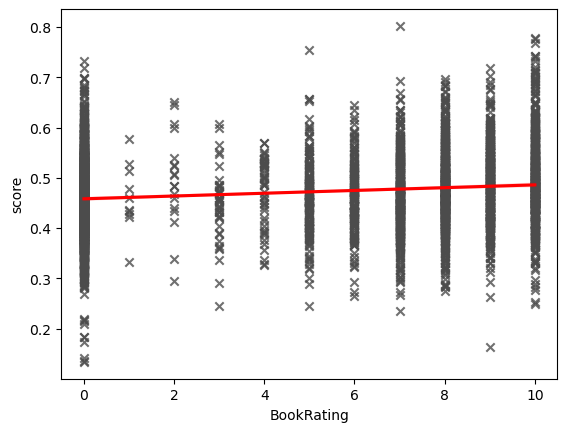

In [74]:
results_sample = results_df.sample(frac=0.05)
sns.regplot(
    data=results_sample, 
    x="BookRating", 
    y="score", 
    ci=99, 
    marker="x", 
    color=".3", 
    line_kws=dict(color="r"),
)
plt.show()

We eliminate the ratings 1-4 from the plot because there weren't many training samples in this range.
As we can see, the trend is to increase the score when the true rating is larger.
Books with a true rating of 10 reach higher than every other rating.


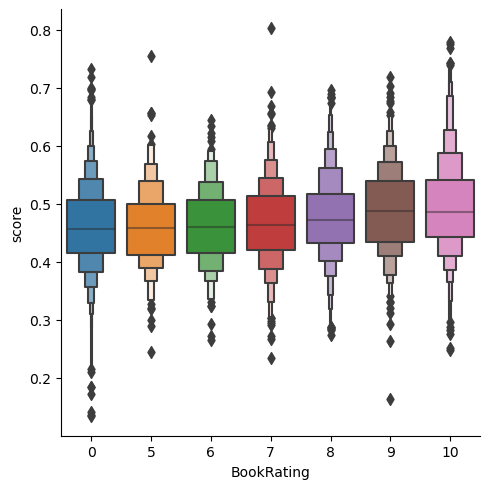

In [84]:
print("We eliminate the ratings 1-4 from the plot because there weren't many training samples in this range.")
print("As we can see, the trend is to increase the score when the true rating is larger.")
print("Books with a true rating of 10 reach higher than every other rating.")
g = sns.catplot(
    data=results_sample[(results_sample.BookRating == 0) | (results_sample.BookRating >= 5)], 
    x="BookRating", 
    y="score",
    kind="boxen",
)

<a id="Top-N-Relevance"></a>
### Top N Relevance
Here we can see that in the top 25 and top 100 samples (sorted using each model's prediction):
1. We have more relevant samples (with true ratings >= 7) using the factorization machine model. In top 25 we have 68% relevant samples vs. 60% with B01. In top 100 we have 75% relevant samples vs. 59% with B01.
2. The percentage of terrible recommendations (with true rating of 0) decreases from 40% using B01 to 10% using FM for top 25, and from 35% to 18% for top 100.
3. The percentage of excellent recommendation (with true rating of 10) increases from 24% using B01 to 43% using FM for top 25, and from 25% to 44% for top 100.

These facts mean that the FM performs better than the baseline model B01 by recommending a higher number of relevant books, and the irrelevant books have a larger rating, even if they are still not relevant.

In [45]:
results_df_context_size = results_df[results_df.ContextSize == 5]

In [46]:
from matplotlib.gridspec import SubplotSpec
from typing import Any

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    """
    Sign sets of subplots with title. See https://stackoverflow.com/a/67165729.
    """
    row = fig.add_subplot(grid)
    row.set_title(f"{title}\n", fontweight="semibold")
    row.set_frame_on(False)
    row.axis("off")
    
def get_data_and_title(size: int, sortby: str) -> Tuple[pd.DataFrame, str]:
    data = results_df_context_size.nlargest(size, sortby)
    title = f"Top {size}"
    if size >= len(results_df_context_size):
        title = "Entire test subset"
    return data, title

def prob_histplot(data: pd.DataFrame, x: str, title: str, axis: Any, bins: int):
    plot = sns.histplot(
        data=data, 
        x=x, 
        stat="probability", 
        ax=axis,
        bins=bins,
    )
    plot.set(title=title)
    plot.set(ylabel="Frequency")
    return plot
    
sizes = [25, 100, 1000, 20000]
ncols = len(sizes)

sort_criteria = ["score", "PredictionFromAverage"]    
nrows = len(sort_criteria)

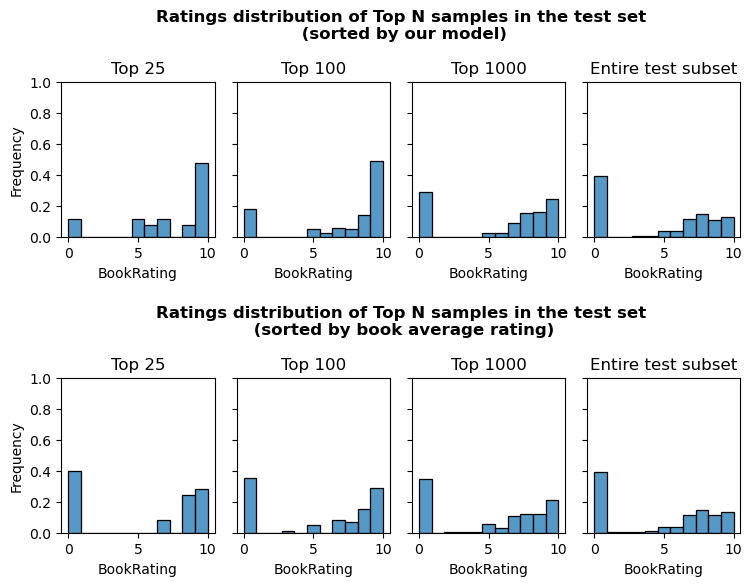

In [54]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(8,6))
fig.tight_layout(h_pad=8.0, w_pad=0, rect=(0.03, 0.05, 0.97, 0.9))

row_titles = [
    "Ratings distribution of Top N samples in the test set\n (sorted by our model)\n",
    "Ratings distribution of Top N samples in the test set\n (sorted by book average rating)\n",
]

for ax in axs.flatten():
    ax.set_ylim(0, 1.0)

grid = plt.GridSpec(nrows, ncols)
for row in range(nrows):
    for col in range(ncols):
        data, title = get_data_and_title(size=sizes[col], sortby=sort_criteria[row])
        prob_histplot(data=data, x="BookRating", title=title, axis=axs[row, col], bins=11)
    create_subtitle(fig, grid[row, ::], row_titles[row])
    
ratings_figure_fpath = "./ratings_distribution.png"
plt.savefig(ratings_figure_fpath)

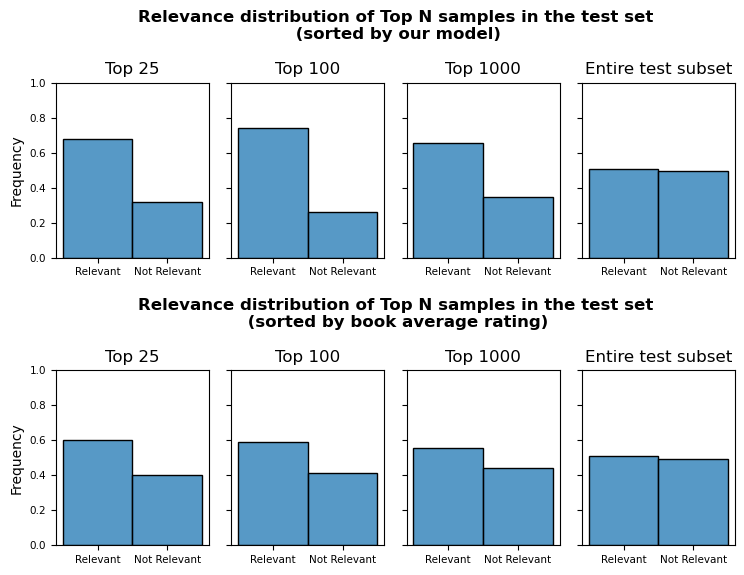

In [57]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(8,6))
fig.tight_layout(h_pad=6.0, w_pad=0, rect=(0.03, 0.03, 0.97, 0.9))

row_titles = [
    "Relevance distribution of Top N samples in the test set\n (sorted by our model)\n",
    "Relevance distribution of Top N samples in the test set\n (sorted by book average rating)\n",
]

for ax in axs.flatten():
    ax.set_ylim(0, 1.0)

grid = plt.GridSpec(nrows, ncols)
for row in range(nrows):
    for col in range(ncols):
        data, title = get_data_and_title(size=sizes[col], sortby=sort_criteria[row])
        plot = prob_histplot(data=data, x="Relevance", title=title, axis=axs[row, col], bins=2)
        plot.set(xlabel=None)
        plot.tick_params(labelsize=7.5)
    create_subtitle(fig, grid[row, ::], row_titles[row])
    
relevance_figure_fpath = "./relevance_distribution.png"
plt.savefig(relevance_figure_fpath)